In [1]:
import os
os.chdir("..")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import mapping, box, Point
from shapely.ops import unary_union
from rasterio.features import geometry_mask
from affine import Affine
import geopandas as gpd
from SSTImportanceSampling  import Preprocessor, ImportanceSampler, StormDepthProcessor

In [3]:
denton = Preprocessor.load(config_path = "/workspaces/Importance-Sampling-for-SST/data/1_interim/Denton/config.json")

In [367]:
# Transpose and average precip + max over watershed
def sample_one_transposed_precip(
    precip_cube,            # xr.DataArray with dims: (storm_path, y, x)
    storm_centers,          # pd.DataFrame with columns: ['storm_path','x','y']
    watershed_gdf,          # GeoDataFrame in SAME CRS/grid as precip_cube
    x_new: float,
    y_new: float,
    seed: int | None = None,
):
    """
    Randomly pick one storm (storm_path), shift it to (x_new, y_new), truncate wrapped
    edges, mask to watershed, and return:
      - precip_avg_mm: watershed-average precipitation (mm)
      - precip_max_mm: watershed-maximum gridcell precipitation (mm)
      - x_max, y_max: grid coordinates of that max cell
    """
    rng = np.random.default_rng(seed)

    # Grid & transform
    x_coords = precip_cube.coords["x"].values
    y_coords = precip_cube.coords["y"].values
    dx = float(np.mean(np.diff(x_coords)))
    dy = float(np.mean(np.diff(y_coords)))

    transform = (Affine.translation(x_coords[0] - dx/2.0, y_coords[0] - dy/2.0)
                 * Affine.scale(dx, dy))

    # Watershed mask (True inside watershed)
    ws_mask = geometry_mask(
        geometries=[mapping(geom) for geom in watershed_gdf.geometry],
        out_shape=(len(y_coords), len(x_coords)),
        transform=transform,
        invert=True,
    )

    # Pick a random storm
    storm_paths = precip_cube.coords["storm_path"].values
    storm_path = rng.choice(storm_paths)
    storm_idx = int(np.where(storm_paths == storm_path)[0][0])

    # Original center
    centers = storm_centers.set_index("storm_path")
    if storm_path not in centers.index:
        raise ValueError(f"storm_path '{storm_path}' not found in storm_centers.")
    x_orig, y_orig = centers.loc[storm_path, ["x", "y"]]

    # Shift (roll) by whole cells and zero wrapped edges
    dx_cells = int(round((x_new - x_orig) / dx))
    dy_cells = int(round((y_new - y_orig) / dy))

    precip = precip_cube.isel(storm_path=storm_idx).values  # (y, x)
    shifted = np.roll(precip, shift=(dy_cells, dx_cells), axis=(0, 1)).astype(float)

    if dy_cells > 0:
        shifted[:dy_cells, :] = 0
    elif dy_cells < 0:
        shifted[dy_cells:, :] = 0

    if dx_cells > 0:
        shifted[:, :dx_cells] = 0
    elif dx_cells < 0:
        shifted[:, dx_cells:] = 0

    # Replace NaNs with 0 before masking
    shifted = np.where(np.isnan(shifted), 0.0, shifted)

    # Average over watershed
    ws_ncells = int(ws_mask.sum())
    if ws_ncells == 0:
        raise ValueError("Watershed mask is empty; check CRS/grid alignment.")
    masked_sum = float((shifted * ws_mask).sum())
    precip_avg_mm = masked_sum / ws_ncells

    # Max over watershed (and its location)
    # Use -inf outside watershed so argmax ignores non-watershed cells
    masked_for_max = np.where(ws_mask, shifted, -np.inf)
    iy, ix = np.unravel_index(np.nanargmax(masked_for_max), masked_for_max.shape)
    precip_max_mm = float(masked_for_max[iy, ix])

    return {
        "storm_path": str(storm_path),
        "x_orig": float(x_orig), "y_orig": float(y_orig),
        "dx_cells": int(dx_cells), "dy_cells": int(dy_cells),
        "precip_avg_mm": float(precip_avg_mm),
        "precip_max_mm": float(precip_max_mm),
    }

In [368]:
#Domain area and bounding box
np.random.seed(42)
domain_gdf = denton.domain_gdf.copy()
domain_gdf = domain_gdf.explode(index_parts=False).reset_index(drop=True)
domain_geom = unary_union(domain_gdf.geometry.values)
assert domain_geom.is_valid

xmin, ymin, xmax, ymax = domain_geom.bounds
bbox_geom = box(xmin, ymin, xmax, ymax)

A_domain = domain_geom.area
A_bbox   = bbox_geom.area

A_domain, A_bbox

(919751892774.4385, 1726372206862.3167)

In [369]:
# Total budget split into iterations
N_total = 4000
T = 10
B = N_total // T   # batch per iteration

# Split controls
n_min_to_split = 10          # min samples in a leaf before it can be split
max_depth = 20               # safety cap
min_leaf_area_frac = 1e-5    # don't keep children with negligible area
eps_var = 1e-12              # tiny epsilon in scores

In [370]:
# --- Initial grid of leaves
nx0, ny0 = 15, 10
dx0 = (xmax - xmin) / nx0
dy0 = (ymax - ymin) / ny0

rows = []
leaf_id = 0
for i in range(nx0):
    for j in range(ny0):
        x0 = xmin + i * dx0
        x1 = xmin + (i + 1) * dx0
        y0 = ymin + j * dy0
        y1 = ymin + (j + 1) * dy0
        b = box(x0, y0, x1, y1)
        a_in = b.intersection(domain_geom).area
        if a_in > 0:  # keep only bins that intersect the polygon
            rows.append({
                "leaf_id": leaf_id,
                "x_min": x0, "x_max": x1, "y_min": y0, "y_max": y1,
                "area_in_domain": a_in,
                "n": 0, "mean": 0.0, "m2": 0.0, "var": np.nan,
                "depth": 0, "active": True, "alloc": 0
            })
            leaf_id += 1

leaves = pd.DataFrame(rows).reset_index(drop=True)
print(f"Initial active leaves: {len(leaves)} (from {nx0*ny0} bins)")
leaves.head()

Initial active leaves: 104 (from 150 bins)


,leaf_id,x_min,x_max,y_min,y_max,area_in_domain,n,mean,m2,var,depth,active,alloc
0,0,-315046.535275,-203221.839056,415548.678398,518470.022563,8.807680e+07,0,0.0,0.0,NaN,0,True,0
1,1,-315046.535275,-203221.839056,518470.022563,621391.366728,1.931821e+09,0,0.0,0.0,NaN,0,True,0
2,2,-315046.535275,-203221.839056,621391.366728,724312.710893,9.551131e+09,0,0.0,0.0,NaN,0,True,0
3,3,-315046.535275,-203221.839056,724312.710893,827234.055058,8.127701e+09,0,0.0,0.0,NaN,0,True,0
4,4,-315046.535275,-203221.839056,827234.055058,930155.399223,7.922862e+09,0,0.0,0.0,NaN,0,True,0


In [371]:
samples = pd.DataFrame(columns=["iter","leaf_id","x","y","g"])
samples

,iter,leaf_id,x,y,g


In [372]:
#Checkpoints
from pathlib import Path
import json, pickle

CKPT = Path("/workspaces/Importance-Sampling-for-SST/data/1_interim/Denton/checkpoints")
CKPT.mkdir(exist_ok=True)

# Initialize IDs if not present
if "sample_id" not in samples.columns:
    samples = samples.copy()
    samples["sample_id"] = pd.RangeIndex(start=0, stop=len(samples), step=1, dtype=int)

# Keep a small config file
cfg = dict(
    B=int(B),
    eps_var=float(eps_var),
    n_min_to_split=int(n_min_to_split),
    max_depth=int(max_depth),
    min_leaf_area_frac=float(min_leaf_area_frac),
    A_domain=float(A_domain),
    domain_crs=str(domain_gdf.crs)
)
with open(CKPT/"config.json","w") as f:
    json.dump(cfg, f, indent=2)

In [373]:
#Step 1
t = 1
act_idx = leaves.index[leaves["active"]].to_list()
if len(act_idx) == 0:
    raise RuntimeError("No active leaves to allocate to.")

# 1) Build tempered, blended scores
eps = float(eps_var)

area = leaves.loc[act_idx, "area_in_domain"].astype(float)
var  = leaves.loc[act_idx, "var"].fillna(0.0).clip(lower=0.0)

# Blend between area-only and (Neyman) std×area, then temper to flatten extremes
lam   = 0.6   # 0 = pure area, 1 = pure Neyman
alpha = 0.7   # 0<alpha<=1; smaller -> flatter

score_neyman = np.sqrt(var + eps) * area       # ∝ σ_j * A_j
score_area   = area.copy()
scores_raw   = lam * score_neyman + (1 - lam) * score_area
scores       = np.power(scores_raw, alpha)

# Fallback if first iter has no data
if (leaves.loc[act_idx, "n"] <= 0).all() or scores.sum() <= 0:
    scores = area.copy()

# 2) Baseline floor: 1 per active leaf only if feasible
alloc = pd.Series(0, index=act_idx, dtype=int)
if B >= len(act_idx):
    alloc += 1
    B_rem = B - len(act_idx)
else:
    B_rem = B  # no floor if budget is too small

# 3) Proportional + fractional rounding for the remainder
weights     = scores / scores.sum()
alloc_float = B_rem * weights

alloc += np.floor(alloc_float).astype(int)
R = B - int(alloc.sum())

if R > 0:
    # give extra units to largest fractional parts (fair rounding)
    frac = (alloc_float - np.floor(alloc_float)).sort_values(ascending=False)
    alloc.loc[frac.index[:R]] += 1

# 4) Soft per-leaf cap (optional): prevent one cell from taking too much
cap_frac = 0.05             # e.g., ≤5% of B per leaf
cap_min  = 6                # but allow at least this many if warranted
cap = max(int(np.ceil(cap_frac * B)), cap_min)

over = alloc - np.minimum(alloc, cap)
extra = int(over[over > 0].sum())
if extra > 0:
    # clip to cap, then re-distribute the overage to under-cap leaves by weights
    alloc[alloc > cap] = cap
    under = alloc.index[alloc < cap]
    if len(under) > 0:
        w_under = (weights.loc[under] / weights.loc[under].sum()).fillna(0.0)
        add_float = extra * w_under
        alloc.loc[under] += np.floor(add_float).astype(int)
        R2 = B - int(alloc.sum())
        if R2 > 0:
            frac2 = (add_float - np.floor(add_float)).sort_values(ascending=False)
            alloc.loc[frac2.index[:R2]] += 1

# 5) Write back
leaves.loc[:, "alloc"] = 0
leaves.loc[alloc.index, "alloc"] = alloc.values

print("Active leaves:", len(act_idx))
print("Planned total alloc (active):", int(leaves.loc[leaves["active"], "alloc"].sum()))
print("Planned total alloc (all):   ", int(leaves["alloc"].sum()))
display(leaves.loc[leaves["active"], ["leaf_id","alloc","n","var","area_in_domain"]]
        .sort_values("alloc", ascending=False).head(2))


Active leaves: 104
Planned total alloc (active): 400
Planned total alloc (all):    400


,leaf_id,alloc,n,var,area_in_domain
19,19,5,0,NaN,1.150915e+10
18,18,5,0,NaN,1.150915e+10


In [374]:
#Step 2
new_rows = []
for _, row in leaves[leaves["active"]].iterrows():
    K = int(row["alloc"])
    if K <= 0:
        continue

    x0, x1 = row["x_min"], row["x_max"]
    y0, y1 = row["y_min"], row["y_max"]

    # clip the leaf to the domain to improve acceptance
    leaf_clip = box(x0, y0, x1, y1).intersection(domain_geom)
    if leaf_clip.is_empty:
        continue

    kept, attempts = 0, 0
    xs, ys = [], []

    # be generous on attempts for skinny boundary cells
    max_attempts = max(K * 200, 5000)

    while kept < K and attempts < max_attempts:
        attempts += 1
        xr = np.random.uniform(x0, x1)
        yr = np.random.uniform(y0, y1)
        # covers -> accept boundary too; more robust than contains
        if leaf_clip.covers(Point(xr, yr)):
            xs.append(xr); ys.append(yr)
            kept += 1

    if kept < K:
        print(f"[iter {t}] WARN leaf {int(row['leaf_id'])}: planned={K}, kept={kept}, attempts={attempts}")

    # append ONLY what you actually kept (prevents IndexError)
    for x, y in zip(xs, ys):
        new_rows.append({"iter": t, "leaf_id": row["leaf_id"], "x": x, "y": y, "g": np.nan})

print("rows built:", len(new_rows), " planned B:", int(leaves.loc[leaves["active"], "alloc"].sum()))

rows built: 400  planned B: 400


In [375]:
#Step 3
new_df = pd.DataFrame(new_rows).reset_index(drop=True)

# Compute watershed-avg precip for each sample by randomly picking a storm and transposing
g_vals = np.empty(len(new_df), dtype=float)
storm_used = np.empty(len(new_df), dtype=object)
dx_cells_used = np.empty(len(new_df), dtype=int)
dy_cells_used = np.empty(len(new_df), dtype=int)
x_orig_used = np.empty(len(new_df), dtype=float)
y_orig_used = np.empty(len(new_df), dtype=float)
max_p = np.empty(len(new_df), dtype=float)

for i in new_df.index:
    x_new = float(new_df.at[i, "x"])
    y_new = float(new_df.at[i, "y"])

    out = sample_one_transposed_precip(
        precip_cube=denton.cumulative_precip,
        storm_centers=denton.storm_centers,
        watershed_gdf=denton.watershed_gdf,
        x_new=x_new,
        y_new=y_new,
        seed=None,          # or set an int for reproducibility
    )

    g_vals[i]         = out["precip_avg_mm"]
    storm_used[i]     = out["storm_path"]
    dx_cells_used[i]  = out["dx_cells"]
    dy_cells_used[i]  = out["dy_cells"]
    x_orig_used[i]    = out["x_orig"]
    y_orig_used[i]    = out["y_orig"]
    max_p[i]          = out["precip_max_mm"]

# Attach results
new_df["g"] = g_vals
new_df["storm_path"] = storm_used
new_df["dx_cells"] = dx_cells_used
new_df["dy_cells"] = dy_cells_used
new_df["x_orig"] = x_orig_used
new_df["y_orig"] = y_orig_used
new_df["max_p"]  = max_p 

# Append to the running samples table
samples = pd.concat([samples, new_df], ignore_index=True)

new_df.head()

/tmp/ipykernel_77259/2688260290.py:44: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  samples = pd.concat([samples, new_df], ignore_index=True)


,iter,leaf_id,x,y,g,storm_path,dx_cells,dy_cells,x_orig,y_orig,max_p
0,1,0,-204787.265841,493087.373889,0.000000,19900306_72hr_st1_r232,-115,-186,254000.0,1238000.0,0.000000
1,1,1,-207451.882331,557052.206495,0.000000,20131030_72hr_st1_r159,-35,-89,-66000.0,914000.0,0.000000
2,1,2,-283096.868020,710788.756542,103.470178,20130108_72hr_st5_r084,-153,-8,330000.0,742000.0,128.100006
3,1,2,-290042.998557,720527.525217,0.000000,19831121_72hr_st1_r345,-185,-93,450000.0,1094000.0,0.000000
4,1,2,-310220.191232,713109.013833,25.082458,19950409_72hr_st1_r220,-172,-46,378000.0,898000.0,30.800001


In [360]:
#Checkpoint
# Ensure unique sample_id for this new batch
next_id = 0 if samples.empty else int(samples["sample_id"].max()) + 1
new_df = new_df.copy()
new_df.insert(0, "sample_id", np.arange(next_id, next_id + len(new_df), dtype=int))

if len(new_df):
    kept_per_leaf = new_df.groupby("leaf_id").size().rename("kept").reset_index()
    total_kept = len(new_df)
    kept_per_leaf["a_jt"] = kept_per_leaf["kept"] / total_kept
    kept_per_leaf = kept_per_leaf.merge(leaves[["leaf_id","area_in_domain"]], on="leaf_id", how="left")
    kept_per_leaf["w_uniform"] = kept_per_leaf["area_in_domain"] / (A_domain * kept_per_leaf["a_jt"])
    new_df = new_df.merge(kept_per_leaf[["leaf_id","a_jt","w_uniform"]], on="leaf_id", how="left")

new_df.to_parquet(CKPT/f"new_points_t{t}.parquet", index=False)

gpd.GeoDataFrame(new_df, geometry=gpd.points_from_xy(new_df["x"], new_df["y"]), crs=domain_gdf.crs) \
    .to_file(CKPT/f"new_points_t{t}.gpkg", layer=f"samples_t{t}", driver="GPKG")

In [349]:
#Step 4
# Update each active leaf with its new samples (Welford's online algorithm)
for leaf_id in leaves.loc[leaves["active"], "leaf_id"].tolist():
    sel = new_df["leaf_id"] == leaf_id
    vals = new_df.loc[sel, "g"].to_numpy()
    if vals.size == 0:
        continue

    j = leaves.index[leaves["leaf_id"] == leaf_id][0]
    n = int(leaves.at[j, "n"])
    mean = float(leaves.at[j, "mean"])
    m2 = float(leaves.at[j, "m2"])

    for v in vals:
        n += 1
        delta = v - mean
        mean += delta / n
        m2 += delta * (v - mean)

    leaves.at[j, "n"] = n
    leaves.at[j, "mean"] = mean
    leaves.at[j, "m2"] = m2
    leaves.at[j, "var"] = (m2 / (n - 1)) if n > 1 else np.nan

leaves[["leaf_id","n","mean","var","area_in_domain","depth","active"]]

,leaf_id,n,mean,var,area_in_domain,depth,active
0,0,10,4.630351,100.763520,8.807680e+07,0,True
1,1,12,8.875730,533.104176,1.931821e+09,0,True
2,2,12,13.032603,1201.024548,9.551131e+09,0,False
3,3,21,33.548538,1993.098329,8.127701e+09,0,False
4,4,18,34.479727,2221.142952,7.922862e+09,0,False
...,...,...,...,...,...,...,...
414,414,1,56.726304,NaN,7.193218e+08,2,True
415,415,1,71.188597,NaN,7.193218e+08,2,True
416,416,1,28.884214,NaN,7.193218e+08,2,True
417,417,1,69.568420,NaN,7.193218e+08,2,True


In [350]:
# --- Step 6: Split multiple leaves this iteration (quad-split: both x and y) ---

K_split = 10  # how many parents to split per iteration

# 1) Eligible candidates
candidates = leaves[
    (leaves["active"]) &
    (leaves["n"] >= n_min_to_split) &
    (leaves["depth"] < max_depth)
].copy()

# 2) Score = variance × area (same as before)
candidates["score"] = candidates["var"].fillna(0.0) * candidates["area_in_domain"]

# 3) Pick top-K by score (>0)
candidates = candidates[candidates["score"] > 0]
to_split_idx = candidates.sort_values("score", ascending=False).index[:K_split]

new_rows = []
parents_to_deactivate = []
next_id = int(leaves["leaf_id"].max()) + 1

# 4) Quad-split each selected parent
for j in to_split_idx:
    leaf = leaves.loc[j].copy()
    xL, xU = float(leaf["x_min"]), float(leaf["x_max"])
    yL, yU = float(leaf["y_min"]), float(leaf["y_max"])

    # skip degenerate
    if (xU - xL) <= 0 or (yU - yL) <= 0:
        continue

    x_mid = 0.5 * (xL + xU)
    y_mid = 0.5 * (yL + yU)

    child_boxes = [
        box(xL,    yL,    x_mid, y_mid),  # SW
        box(x_mid, yL,    xU,    y_mid),  # SE
        box(xL,    y_mid, x_mid, yU),     # NW
        box(x_mid, y_mid, xU,    yU),     # NE
    ]

    made_children = 0
    for b in child_boxes:
        a_in = b.intersection(domain_geom).area
        if a_in >= (min_leaf_area_frac * A_domain):
            new_rows.append({
                "leaf_id": next_id,
                "x_min": b.bounds[0], "x_max": b.bounds[2],
                "y_min": b.bounds[1], "y_max": b.bounds[3],
                "area_in_domain": a_in,
                "n": 0, "mean": 0.0, "m2": 0.0, "var": np.nan,
                "depth": int(leaf["depth"]) + 1,
                "active": True, "alloc": 0
            })
            next_id += 1
            made_children += 1

    # Deactivate parent only if children were created
    if made_children > 0:
        parents_to_deactivate.append(j)

# 5) Apply updates
if parents_to_deactivate:
    leaves.loc[parents_to_deactivate, "active"] = False
    leaves.loc[parents_to_deactivate, "alloc"]  = 0

if new_rows:
    leaves = pd.concat([leaves, pd.DataFrame(new_rows)], ignore_index=True)

print(f"[iter {t}] quad-split {len(parents_to_deactivate)} parents → added {len(new_rows)} children (K_split={K_split})")
# Optional quick view
leaves.sort_values(["active", "depth", "leaf_id"])


[iter 10] quad-split 10 parents → added 40 children (K_split=10)


,leaf_id,x_min,x_max,y_min,y_max,area_in_domain,n,mean,m2,var,depth,active,alloc
2,2,-315046.535275,-203221.839056,6.213914e+05,7.243127e+05,9.551131e+09,12,13.032603,13211.270024,1201.024548,0,False,0
3,3,-315046.535275,-203221.839056,7.243127e+05,8.272341e+05,8.127701e+09,21,33.548538,39861.966576,1993.098329,0,False,0
4,4,-315046.535275,-203221.839056,8.272341e+05,9.301554e+05,7.922862e+09,18,34.479727,37759.430178,2221.142952,0,False,0
5,5,-315046.535275,-203221.839056,9.301554e+05,1.033077e+06,7.920232e+09,13,74.541093,49950.481597,4162.540133,0,False,0
6,6,-315046.535275,-203221.839056,1.033077e+06,1.135998e+06,1.055672e+10,10,86.521051,17824.219335,1980.468815,0,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
454,454,48383.727438,76339.901493,1.264650e+06,1.290380e+06,4.182735e+07,0,0.000000,0.000000,NaN,2,True,0
455,455,-91397.142836,-63440.968781,9.301554e+05,9.558857e+05,7.193218e+08,0,0.000000,0.000000,NaN,2,True,0
456,456,-63440.968781,-35484.794727,9.301554e+05,9.558857e+05,7.193218e+08,0,0.000000,0.000000,NaN,2,True,0
457,457,-91397.142836,-63440.968781,9.558857e+05,9.816161e+05,7.193218e+08,0,0.000000,0.000000,NaN,2,True,0


In [361]:
import time, os

stamp = time.strftime("%Y%m%d_%H%M%S")
# 1) Big tables
samples.to_parquet(CKPT/f"samples_latest.parquet", index=False)
samples.to_parquet(CKPT/f"samples_t{t}_{stamp}.parquet", index=False)

leaves.to_parquet(CKPT/f"leaves_latest.parquet", index=False)
leaves.to_parquet(CKPT/f"leaves_t{t}_{stamp}.parquet", index=False)

# 2) Optional logs
# alloc_log: per-iter allocation vs kept
if 'alloc_log' in globals():
    alloc_log.to_parquet(CKPT/"alloc_log.parquet", index=False)

# split_log: rows like (iter, parent_leaf_id, child_leaf_id)
if 'split_log' in globals():
    split_log.to_parquet(CKPT/"split_log.parquet", index=False)

# 3) Next IDs & iteration pointer
state = dict(
    t=int(t),
    next_leaf_id=int(leaves["leaf_id"].max()) + 1,
    next_sample_id=int(samples["sample_id"].max()) + 1
)
with open(CKPT/"state.json","w") as f:
    json.dump(state, f, indent=2)

# 4) RNG state (optional)
with open(CKPT/"rng_state.pkl","wb") as f:
    pickle.dump(np.random.get_state(), f)


In [ ]:
#To resume if crashed
# Load the latest state
leaves  = pd.read_parquet(CKPT/"leaves_latest.parquet")
samples = pd.read_parquet(CKPT/"samples_latest.parquet")

with open(CKPT/"state.json") as f:
    s = json.load(f)
t = int(s.get("t", 0)) + 1  # next iteration number
next_leaf_id   = int(s.get("next_leaf_id", int(leaves["leaf_id"].max()) + 1))
next_sample_id = int(s.get("next_sample_id", int(samples["sample_id"].max()) + 1))

# Optional RNG restore
try:
    import pickle
    with open(CKPT/"rng_state.pkl","rb") as f:
        np.random.set_state(pickle.load(f))
except FileNotFoundError:
    pass

# Rebuild geometry helpers if needed
domain_series = gpd.read_file(CKPT/"domain.gpkg", layer="domain")
domain_geom = domain_series.geometry.iloc[0]
watershed_gdf = gpd.read_file(CKPT/"watershed.gpkg", layer="watershed")

<h1>Plots</h1>

/tmp/ipykernel_77259/2378858632.py:37: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc="upper right")


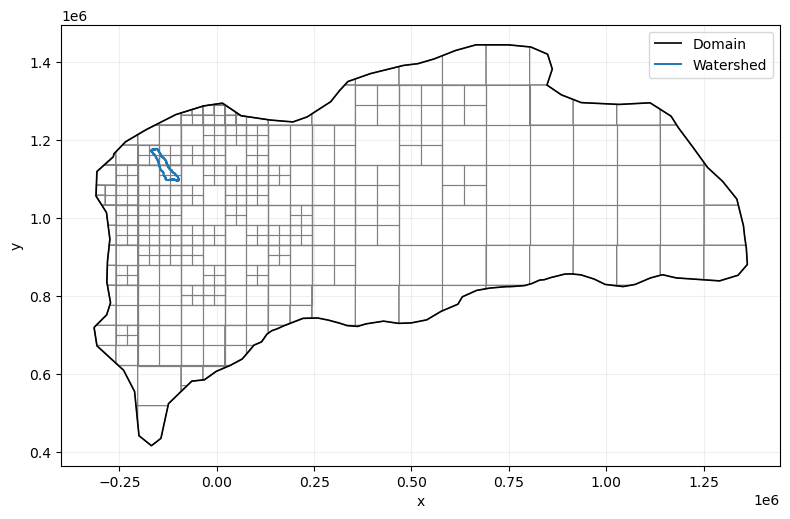

In [351]:
watershed_gdf = denton.watershed_gdf

# --- Build clipped grid GeoDataFrame from your `leaves` table ---
leaf_clipped_geoms = []
for _, r in leaves.iterrows():
    rect = box(r["x_min"], r["y_min"], r["x_max"], r["y_max"])
    clipped = rect.intersection(domain_geom)
    if not clipped.is_empty:
        leaf_clipped_geoms.append(clipped)
    else:
        leaf_clipped_geoms.append(None)

leaf_gdf = gpd.GeoDataFrame(leaves.copy(), geometry=leaf_clipped_geoms, crs=domain_gdf.crs)
leaf_gdf = leaf_gdf[~leaf_gdf.geometry.is_empty & leaf_gdf.geometry.notnull()].copy()

# Ensure watershed is in same CRS as domain
ws_plot = watershed_gdf if watershed_gdf.crs == domain_gdf.crs else watershed_gdf.to_crs(domain_gdf.crs)

# --- Plot ---
fig, ax = plt.subplots(figsize=(8,8))

# Domain boundary
gpd.GeoSeries([domain_geom], crs=domain_gdf.crs).boundary.plot(
    ax=ax, color="black", linewidth=1.2, label="Domain"
)

# Watershed boundary
ws_plot.boundary.plot(ax=ax, color="tab:blue", linewidth=1.4, label="Watershed")

# Clipped grid cells
leaf_gdf.plot(ax=ax, facecolor="none", edgecolor="gray", linewidth=0.8, label="10×10 grid (clipped)")

ax.set_aspect("equal")
ax.set_xlabel("x"); ax.set_ylabel("y")
ax.set_title("")
ax.grid(True, alpha=0.2)
ax.legend(loc="upper right")
plt.tight_layout()
plt.show()


/tmp/ipykernel_77259/794781175.py:17: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc="upper right")
/tmp/ipykernel_77259/794781175.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc="upper right")


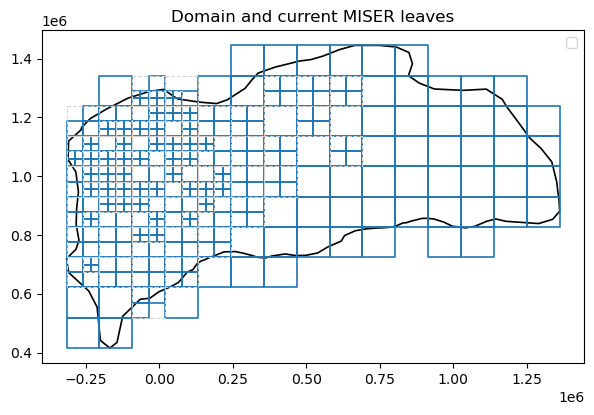

In [352]:
# Build a GeoDataFrame of rectangular leaves (polygons) from the current `leaves` table
leaf_polys = []
for _, r in leaves.iterrows():
    leaf_polys.append(box(r["x_min"], r["y_min"], r["x_max"], r["y_max"]))
leaf_gdf = gpd.GeoDataFrame(leaves.copy(), geometry=leaf_polys, crs=domain_gdf.crs)

fig, ax = plt.subplots(figsize=(7,7))
# Domain
gpd.GeoSeries([domain_geom], crs=domain_gdf.crs).plot(ax=ax, facecolor="none", edgecolor="black", linewidth=1.2, label="Domain")

# Active leaves in one style, inactive in lighter style
leaf_gdf.loc[leaf_gdf["active"]].plot(ax=ax, facecolor="none", edgecolor="tab:blue", linewidth=1.2, label="Active leaf")
leaf_gdf.loc[~leaf_gdf["active"]].plot(ax=ax, facecolor="none", edgecolor="lightgray", linewidth=0.8, linestyle="--", label="Inactive leaf")

ax.set_title("Domain and current MISER leaves")
ax.set_aspect("equal")
ax.legend(loc="upper right")
plt.show()

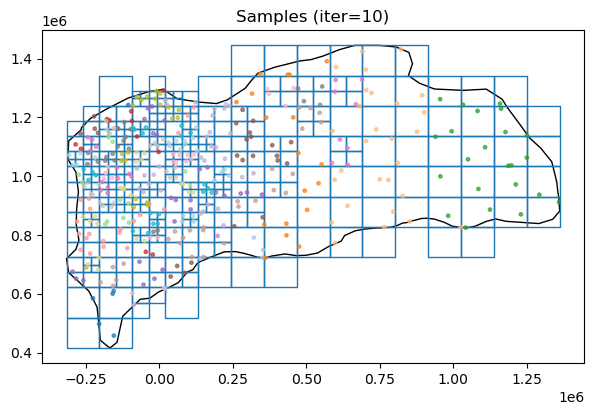

In [353]:
fig, ax = plt.subplots(figsize=(7,7))
gpd.GeoSeries([domain_geom], crs=domain_gdf.crs).plot(ax=ax, facecolor="none", edgecolor="black", linewidth=1.0)

# Draw leaves
leaf_gdf.loc[leaf_gdf["active"]].plot(ax=ax, facecolor="none", edgecolor="tab:blue", linewidth=1.0)

# Choose samples to show:
show_all_samples = False  # <-- switch to True to show all iterations
if show_all_samples:
    S = samples.copy()
    title_suffix = " (all iters)"
else:
    S = samples.loc[samples["iter"]==t].copy()  # current iteration `t`
    title_suffix = f" (iter={t})"

# Plot samples (small dots); color by leaf id to see allocation
if not S.empty:
    ax.scatter(S["x"], S["y"], s=6, alpha=0.7, c=S["leaf_id"], cmap="tab20", marker="o")

ax.set_title(f"Samples{title_suffix}")
ax.set_aspect("equal")
plt.show()

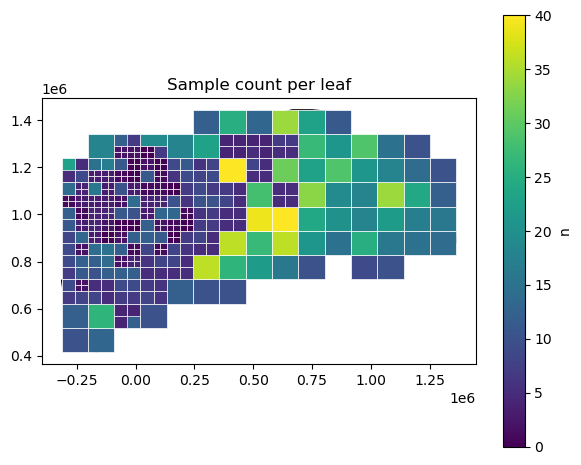

In [354]:
metric = "n"   # choose "n" for count or "var" for variance
title_map = {"n":"Sample count per leaf", "var":"Variance per leaf"}

# Copy current leaves and set a color column
leaf_plot = leaf_gdf.copy()
vals = leaf_plot[metric].fillna(0.0)
# Avoid degenerate all-zeros for colormap
vmax = max(vals.max(), 1e-12)

fig, ax = plt.subplots(figsize=(7,7))
gpd.GeoSeries([domain_geom], crs=domain_gdf.crs).plot(ax=ax, facecolor="none", edgecolor="black", linewidth=1.0)
leaf_plot.plot(ax=ax, column=metric, cmap="viridis", vmin=0, vmax=vmax, linewidth=0.5, edgecolor="white")
ax.set_title(title_map[metric])
ax.set_aspect("equal")

# Optional colorbar
mappable = plt.cm.ScalarMappable(cmap="viridis")
mappable.set_array(vals)
mappable.set_clim(0, vmax)
cb = plt.colorbar(mappable, ax=ax, shrink=0.8)
cb.set_label(metric)

plt.show()

/tmp/ipykernel_77259/488544924.py:19: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc="upper right")
/tmp/ipykernel_77259/488544924.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc="upper right")


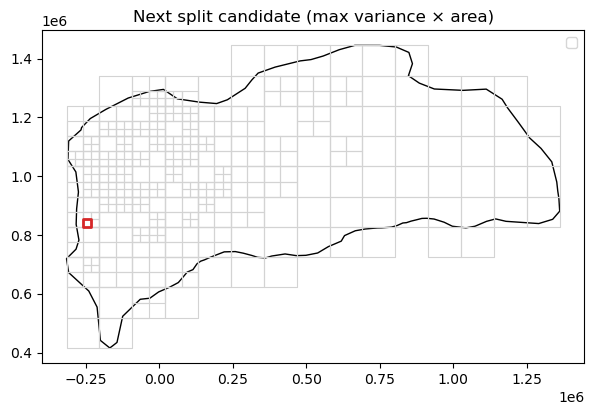

In [355]:
viz = leaves.copy()
viz["score"] = viz["var"].fillna(0.0) * viz["area_in_domain"]
j_star = viz.loc[(viz["active"]) & (viz["n"]>0), "score"].idxmax() if (viz["active"] & (viz["n"]>0)).any() else None

fig, ax = plt.subplots(figsize=(7,7))
gpd.GeoSeries([domain_geom], crs=domain_gdf.crs).plot(ax=ax, facecolor="none", edgecolor="black", linewidth=1.0)

# Draw all leaves
leaf_gdf.plot(ax=ax, facecolor="none", edgecolor="lightgray", linewidth=0.8)

# Highlight candidate to split
if j_star is not None and not np.isnan(viz.at[j_star, "score"]):
    gpd.GeoSeries([leaf_gdf.loc[j_star, "geometry"]], crs=leaf_gdf.crs).plot(
        ax=ax, facecolor="none", edgecolor="tab:red", linewidth=2.0, label="Next split?"
    )

ax.set_title("Next split candidate (max variance × area)")
ax.set_aspect("equal")
ax.legend(loc="upper right")
plt.show()

/tmp/ipykernel_77259/2833841953.py:41: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc="upper right")


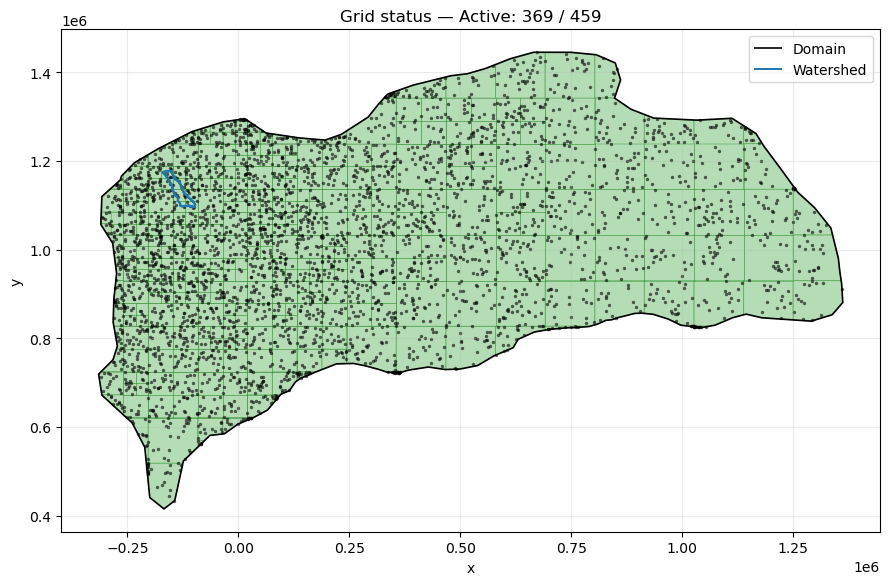

In [357]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box

# --- Build/refresh clipped grid from `leaves` ---
leaf_polys = [box(r["x_min"], r["y_min"], r["x_max"], r["y_max"]) for _, r in leaves.iterrows()]
leaf_gdf = gpd.GeoDataFrame(leaves.copy(), geometry=leaf_polys, crs=domain_gdf.crs)

# Clip each cell to the domain so edges don't spill outside
leaf_gdf["geometry"] = leaf_gdf.geometry.intersection(domain_geom)
leaf_gdf = leaf_gdf[~leaf_gdf.geometry.is_empty & leaf_gdf.geometry.notnull()].copy()

# Split active/inactive
active_gdf   = leaf_gdf[leaf_gdf["active"]].copy()
inactive_gdf = leaf_gdf[~leaf_gdf["active"]].copy()

# Ensure watershed CRS matches domain
ws_plot = watershed_gdf if watershed_gdf.crs == domain_gdf.crs else watershed_gdf.to_crs(domain_gdf.crs)

# --- Plot ---
fig, ax = plt.subplots(figsize=(9,9))

# Domain & watershed boundaries
gpd.GeoSeries([domain_geom], crs=domain_gdf.crs).boundary.plot(ax=ax, color="black", linewidth=1.2, label="Domain")
ws_plot.boundary.plot(ax=ax, color="tab:blue", linewidth=1.4, label="Watershed")

# Inactive leaves: thin gray outlines
if not inactive_gdf.empty:
    inactive_gdf.plot(ax=ax, facecolor="none", edgecolor="lightgray", linewidth=0.6, label="Inactive")

# Active leaves: filled
if not active_gdf.empty:
    active_gdf.plot(ax=ax, facecolor="tab:green", alpha=0.35, edgecolor="forestgreen", linewidth=0.7, label="Active")

# Cosmetics
n_active = int(active_gdf.shape[0]); n_total = int(leaf_gdf.shape[0])
ax.set_aspect("equal")
ax.set_xlabel("x"); ax.set_ylabel("y")
ax.set_title(f"Grid status — Active: {n_active} / {n_total}")
ax.grid(True, alpha=0.25)
ax.legend(loc="upper right")
if ("x" in samples.columns) and ("y" in samples.columns) and (len(samples) > 0):
    ax.scatter(
        samples["x"].values, samples["y"].values,
        s=6, alpha=0.6, linewidths=0, color="k", label=f"Samples (n={len(samples)})"
    )
plt.tight_layout()
plt.show()


In [358]:
samples

,iter,leaf_id,x,y,g,storm_path,dx_cells,dy_cells,x_orig,y_orig
0,1,0,-204787.265841,4.930874e+05,0.000000,20181227_72hr_st1_r131,-222.0,-116.0,682000.0,958000.0
1,1,1,-207451.882331,5.570522e+05,8.291228,20190509_72hr_st1_r063,-209.0,-83.0,630000.0,890000.0
2,1,2,-283096.868020,7.107888e+05,13.820176,19900424_72hr_st1_r198,-53.0,-30.0,-70000.0,830000.0
3,1,2,-290042.998557,7.205275e+05,0.000000,20001123_72hr_st1_r116,-163.0,-113.0,362000.0,1174000.0
4,1,2,-310220.191232,7.131090e+05,0.000000,19830131_72hr_st1_r181,-268.0,-72.0,762000.0,1002000.0
...,...,...,...,...,...,...,...,...,...,...
3994,10,414,57726.208280,1.120044e+06,56.726304,19851028_72hr_st2_r058,-43.0,82.0,230000.0,794000.0
3995,10,415,88677.458239,1.108386e+06,71.188597,20040429_72hr_st1_r303,-118.0,89.0,562000.0,754000.0
3996,10,416,129734.074411,1.086315e+06,28.884214,19820419_72hr_st1_r284,-59.0,17.0,366000.0,1018000.0
3997,10,417,87909.697338,1.118503e+06,69.568420,19800514_72hr_st1_r115,-61.0,82.0,330000.0,790000.0
